## run notebooks

In [1]:
%run "initialization.ipynb"
%run "Input_selection_functions.ipynb"
%run "Downsampling_and_outliers_functions.ipynb"
%run "Stitching_clean.ipynb"
%run "Visualization_functions.ipynb"
%run "Evaluation_functions.ipynb"

%load_ext autoreload

----------------------------------------
loaded variables from initialization file: 
> myparams, myconfiguration_file
> list_picked_id_source, list_picked_id_target
> data_folder
----------------------------------------


### just some handpicked visualization settings for this page

they are fed in "custom_draw_geometry" as for params, ad myconfiguration. 
if you dont want to use them just comment these lines out.

In [3]:
specific_screen, specific_render = specific_visualization_parameters("2Stitch")

loaded visualization options
- ../data/2StitchScreenCamera.json 
- ../data/2StitchRenderOption.json


## Load the pointclouds

In [4]:
# default
all_paths_images,all_paths_ply, num_images,labels,img_folder,ply_folder,all_images,all_ply = load_input(data_folder)

default set:
-imgfolder, contains 30 images 
-plyfolder_1, contains 30 ply  
['imgfolder', 'plyfolder_1']
found labels file: 
['External', 'Internal', 'Upper']


In [3]:
## uncomment following line to select different ply and img folders as input
#all_paths_images,all_paths_ply,num_images,labels,img_folder,ply_folder,,all_images,all_ply = select_input_files(data_folder)

In [14]:
all_seq_pcd = all_files_containing("initial_stitched_seq", extension = ".pcd")

# take most recent 3
all_seq_pcd = sorted(all_seq_pcd[-3:])
print (*all_seq_pcd, sep= "\n")

../data/initial_stitched_seq_2.pcd
../data/initial_stitched_seq_0.pcd
../data/initial_stitched_seq_1.pcd


In [15]:
list_stitches = [o3d.io.read_point_cloud(this_seq) for this_seq in all_seq_pcd]
labels_stitches = ["stitched_%s"%thislab for thislab in labels]
color_stitches = [[1, 0.706, 0],[0, 0.651, 0.929],[0,0.7,0.3]]

## Many plots

Just a visualization, rememeber you can close the windows by pressing Q.

In [16]:
# plot a list of geometries, dynamic
custom_draw_geometry([list_stitches],
                     mytitle = [labels_stitches],
                     #params = myparams,  
                     #configuration_file = myconfiguration_file, 
                     take_screen_shot = False,
                     rotate = True)

[Open3D WARNING] GLFW Error: The GLFW library is not initialized
[Open3D WARNING] GLFW Error: The GLFW library is not initialized
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


In [7]:
labels_stitches

['stitched_External', 'stitched_Internal', 'stitched_Upper']

## Observation

The upper sequence looks like having more areas in common with the external and the internal than internal and external sequences have between themselves. It looks like a reasonable approach to start by stitching the upper sequence with one of the others.

## stitching 1 and 2

In [8]:
i = 1
j = 2

source_label = labels_stitches[i][9:] # just labels parsing
target_label =labels_stitches[j][9:]
source = list_stitches[i]
target = list_stitches[j]

start = timer()
new_source, new_target, newpointcloud ,all_results = stitching_new(
                                                                    #input 
                                                                    source = source, 
                                                                    target = target, 
                                                                    labels= [source_label,target_label],

                                                                    #downsampling 
                                                                    downsampling_voxel_size = 0.1,
                                                                    limit_size_point_cloud = 50000,

                                                                    #registration
                                                                    voxel_size = 0.2,
                                                                    mmax_iteration = 10**7,
                                                                    mmax_validation = 0.7,

                                                                    # quality control of the stitching
                                                                    myoverlapping_factor = 0.5,
                                                                    maxnumattempts = 10,

                                                                    # visualization and pringtng parameters
                                                                    trans_init = None, # keep the possibility of starting directly the ICP
                                                                    print_statements = True,
                                                                    save_statements = False,
                                                                    visualization_on = False,
                                                                    final_vis_on = True,
                                                                    params = myparams,  
                                                                    configuration_file = myconfiguration_file
                                                                 )

end = timer()

print ("duration:",(end-start))

stitch_Internal_Upper

DOWNSAMPLING BIG CLOUDS

Internal
Downsampling Internal from 227233 points with voxel size 0.1 
Downsampling Internal from 83396 points with voxel size 0.15 
Processed Internal has 42891 points 

Upper
Downsampling Upper from 219667 points with voxel size 0.1 
Downsampling Upper from 82944 points with voxel size 0.15 
Processed Upper has 46757 points 

DATA PREPARATION
removing outliers
value to reach:  109833.5
source has 227233 points
target has 219667 points
----------------------------------------------------------------------------------------------------
ATTEMPT 1

GLOBAL REGISTRATION: RANSAC registration on downsampled point clouds.
RegistrationResult with fitness=5.557766e-02, inlier_rmse=1.866660e-01, and correspondence_set size of 419
Access transformation to get result.
Transformation is:
[[  0.98855398  -0.03325005   0.14715794  -8.99397874]
 [ -0.05548063   0.82694119   0.5595446  -27.61103734]
 [ -0.14029585  -0.56130446   0.81563128  12.44908456]
 

[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.


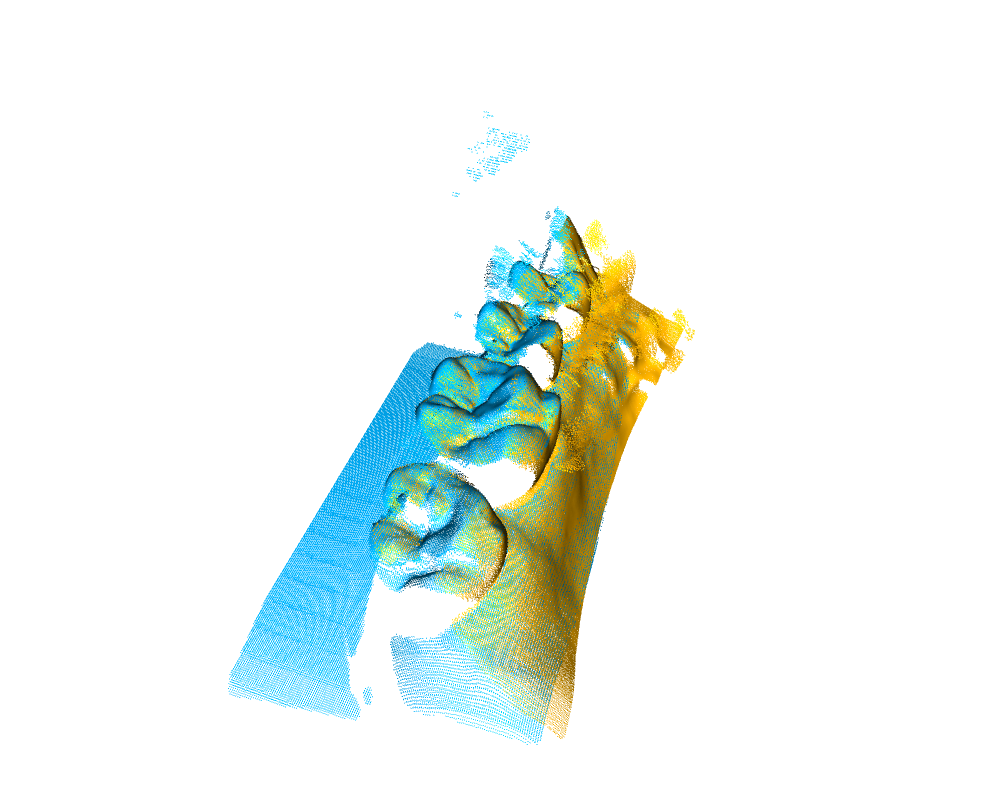

In [11]:
#o3d.visualization.draw_geometries([list_new_pointclouds[-1]])
stitched_seq_1_2 = newpointcloud
results_stitching_1_2 = all_results
tstring = mytimestamp()

custom_draw_geometry(stitched_seq_1_2,
                     mytitle = tstring+ "stitched_seq_1_2",
                     params = myparams,  # parameter for camera point view, json file via pressing P
                     configuration_file = myconfiguration_file, # configuration file for properties, json file via pressing o
                     take_screen_shot = True,
                     rotate = False)

# after manual changing in visualization mode
newest = last_file_containing("stitched_seq_1_2", extension = '.png')
Im(filename=newest,width = 800)

### check on various attempt to get a good stitch

In [12]:
for k,v in results_stitching_1_2.items():
    print (f"\n{k}{dash}")
    print (f" GLOBAL: \n  fitness: {v[0].fitness} \n  inlier_rmse: {v[0].inlier_rmse} \n  correspondence_set: {len(np.asarray(v[0].correspondence_set))}")
    print (f" ICP: \n  fitness: {v[1].fitness} \n  inlier_rmse: {v[1].inlier_rmse} \n  correspondence_set: {len(np.asarray(v[1].correspondence_set))}")


1--------------------------------------------------------------------------------
 GLOBAL: 
  fitness: 0.055577662820002656 
  inlier_rmse: 0.18666596995573415 
  correspondence_set: 419
 ICP: 
  fitness: 0.8371143275844618 
  inlier_rmse: 0.09148482234966757 
  correspondence_set: 190220


Ok in this case our quality condition has been fullfilled at the first attempt, so not much to plot.

## stitching 0 to 1_2

this is the first approach, stitching the third sequence of point clouds.
* how hard is it? 
* how long does it take? 
* is the result acceptable? 

Note that the max number of attempt set to 100 is to retrieve the behaviour of the parameters. **DO NOT RE RUN NEXT CELL if you dont want to wait for quite sometime :)**

If you want to rerun, just set "reruncell" to True.

Also the results might vary at times, but the statistics at the end stand valid.

If this process wont be successfull a possible alternative: stitch 0 to 2 and than 0_2 to 1_2

In [44]:
reruncell = False
if reruncell == True:
    i = 0
    #j = 2

    target_label = labels_stitches[i][9:] # just labels parsing
    source_label = "stitched_seq_1_2"
    target = list_stitches[i]
    source = stitched_seq_1_2

    new_source, new_target, newpointcloud ,all_results = stitching_new(
                                                                        #input 
                                                                        source = source, 
                                                                        target = target, 
                                                                        labels= [source_label,target_label],

                                                                        #downsampling 
                                                                        downsampling_voxel_size = 0.1,
                                                                        limit_size_point_cloud = 50000,

                                                                        #registration
                                                                        voxel_size = 0.2,
                                                                        mmax_iteration = 10**7,
                                                                        mmax_validation = 0.7,

                                                                        #icp registration
                                                                        icp_max_iteration = 1,
                                                                        
                                                                        # quality control of the stitching
                                                                        myoverlapping_factor = 0.5,
                                                                        maxnumattempts = 100,

                                                                        # visualization and pringtng parameters
                                                                        trans_init = None, # keep the possibility of starting directly the ICP
                                                                        print_statements = True,
                                                                        save_statements = False,
                                                                        visualization_on = False,
                                                                        final_vis_on = True,
                                                                        params = myparams,  
                                                                        configuration_file = myconfiguration_file
                                                                     )

stitch_stitched_seq_1_2_External

DOWNSAMPLING BIG CLOUDS

stitched_seq_1_2
Downsampling stitched_seq_1_2 from 446900 points with voxel size 0.1 
Downsampling stitched_seq_1_2 from 134176 points with voxel size 0.15 
Downsampling stitched_seq_1_2 from 69668 points with voxel size 0.2 
Processed stitched_seq_1_2 has 40997 points 

External
Downsampling External from 230491 points with voxel size 0.1 
Downsampling External from 92802 points with voxel size 0.15 
Downsampling External from 55129 points with voxel size 0.2 
Processed External has 33279 points 

DATA PREPARATION
removing outliers
value to reach:  115245.5
source has 446900 points
target has 230491 points
----------------------------------------------------------------------------------------------------
ATTEMPT 1

GLOBAL REGISTRATION: RANSAC registration on downsampled point clouds.
RegistrationResult with fitness=4.497751e-03, inlier_rmse=2.229736e-01, and correspondence_set size of 33
Access transformation to get result.


RegistrationResult with fitness=7.087365e-03, inlier_rmse=1.982851e-01, and correspondence_set size of 52
Access transformation to get result.
Transformation is:
[[  0.98909208  -0.04452419   0.14040818  -6.5240773 ]
 [ -0.02887968   0.87610349   0.48125735 -27.92513599]
 [ -0.14443969  -0.48006278   0.86526118   8.80322481]
 [  0.           0.           0.           1.        ]]

POINT-TO-PLANE ICP registration is applied on original point
distance threshold 0.400.
RegistrationResult with fitness=1.954509e-01, inlier_rmse=1.477159e-01, and correspondence_set size of 87347
Access transformation to get result.
Transformation is:
[[  0.98801237  -0.03377925   0.15063371  -6.96607923]
 [ -0.04504103   0.87023477   0.49057391 -28.23931013]
 [ -0.14765791  -0.49147779   0.85828126   9.18165309]
 [  0.           0.           0.           1.        ]]
Quality of the stitch needs improvment: True
--------------------------------------------------------------------------------------------------

RegistrationResult with fitness=6.951070e-03, inlier_rmse=1.885946e-01, and correspondence_set size of 51
Access transformation to get result.
Transformation is:
[[  0.9888048   -0.04244712   0.14305001  -6.69676738]
 [ -0.03418937   0.86872987   0.49410474 -28.45463427]
 [ -0.14524514  -0.49346393   0.85755303   9.13898111]
 [  0.           0.           0.           1.        ]]

POINT-TO-PLANE ICP registration is applied on original point
distance threshold 0.400.
RegistrationResult with fitness=1.946543e-01, inlier_rmse=1.411548e-01, and correspondence_set size of 86991
Access transformation to get result.
Transformation is:
[[  0.98791762  -0.03344524   0.15132806  -7.01597013]
 [ -0.04760696   0.86373698   0.50168915 -28.69074555]
 [ -0.14748676  -0.50283182   0.85170876   9.46806866]
 [  0.           0.           0.           1.        ]]
Quality of the stitch needs improvment: True
--------------------------------------------------------------------------------------------------

 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

POINT-TO-PLANE ICP registration is applied on original point
distance threshold 0.400.
RegistrationResult with fitness=1.233811e-01, inlier_rmse=2.344948e-01, and correspondence_set size of 55139
Access transformation to get result.
Transformation is:
[[ 9.98041245e-01 -2.25722991e-02 -5.83452144e-02  6.83076204e-01]
 [ 5.97716335e-03  9.62777187e-01 -2.70230201e-01  1.09271298e+01]
 [ 6.22731583e-02  2.69352148e-01  9.61026261e-01  1.65246643e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Quality of the stitch needs improvment: True
----------------------------------------------------------------------------------------------------
ATTEMPT 26

GLOBAL REGISTRATION: RANSAC registration on downsampled point clouds.
RegistrationResult with fitness=2.725910e-03, inlier_rmse=2.016906e-01, and correspondence_set size of 20
Access transformation to get result.
Transformation is:
[[  0.98283704  -0.0

RegistrationResult with fitness=2.044432e-03, inlier_rmse=2.030504e-01, and correspondence_set size of 15
Access transformation to get result.
Transformation is:
[[  0.99064834  -0.07077533   0.11664783  -5.43325392]
 [  0.02589354   0.93692541   0.34856894 -22.82660211]
 [ -0.1339604   -0.34228882   0.92999622   5.96905023]
 [  0.           0.           0.           1.        ]]

POINT-TO-PLANE ICP registration is applied on original point
distance threshold 0.400.
RegistrationResult with fitness=1.751510e-01, inlier_rmse=2.129813e-01, and correspondence_set size of 78275
Access transformation to get result.
Transformation is:
[[ 9.89889866e-01 -5.67701622e-02  1.29981541e-01 -6.06073850e+00]
 [ 6.89060832e-03  9.34573318e-01  3.55703857e-01 -2.30314138e+01]
 [-1.41670646e-01 -3.51211991e-01  9.25515837e-01  6.25792493e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Quality of the stitch needs improvment: True
--------------------------------------------------

RegistrationResult with fitness=1.876885e-01, inlier_rmse=1.417410e-01, and correspondence_set size of 83878
Access transformation to get result.
Transformation is:
[[  0.98853935  -0.03749444   0.14623312  -6.68405454]
 [ -0.0457683    0.84863973   0.52698755 -29.84033505]
 [ -0.14385834  -0.52764077   0.8371977   10.04268862]
 [  0.           0.           0.           1.        ]]
Quality of the stitch needs improvment: True
----------------------------------------------------------------------------------------------------
ATTEMPT 42

GLOBAL REGISTRATION: RANSAC registration on downsampled point clouds.
RegistrationResult with fitness=8.177729e-04, inlier_rmse=1.872532e-01, and correspondence_set size of 6
Access transformation to get result.
Transformation is:
[[ -0.88757093   0.41623253  -0.19740394  29.13535143]
 [ -0.43181076  -0.60242287   0.67128694 -30.25224747]
 [  0.16049081   0.68105592   0.71442672  11.16697183]
 [  0.           0.           0.           1.        ]]

POI

RegistrationResult with fitness=1.800022e-01, inlier_rmse=1.363388e-01, and correspondence_set size of 80443
Access transformation to get result.
Transformation is:
[[ 9.86377065e-01 -7.02295846e-02  1.48755138e-01 -6.91089884e+00]
 [-2.60433462e-02  8.26211705e-01  5.62757464e-01 -3.14426447e+01]
 [-1.62425459e-01 -5.58965137e-01  8.13127263e-01  1.13137278e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Quality of the stitch needs improvment: True
----------------------------------------------------------------------------------------------------
ATTEMPT 50

GLOBAL REGISTRATION: RANSAC registration on downsampled point clouds.
RegistrationResult with fitness=6.814774e-04, inlier_rmse=1.352273e-01, and correspondence_set size of 5
Access transformation to get result.
Transformation is:
[[ 0.84385976  0.51139514 -0.16240601  5.3661236 ]
 [-0.4394184   0.48496502 -0.75612195 39.1534136 ]
 [-0.30791585  0.70942508  0.6339589  13.30647227]
 [ 0.          0.       

RegistrationResult with fitness=1.771841e-03, inlier_rmse=2.153341e-01, and correspondence_set size of 13
Access transformation to get result.
Transformation is:
[[  0.89923869   0.3813696    0.21430585  -8.10770497]
 [ -0.43519238   0.8296793    0.34962817 -14.14985568]
 [ -0.04446757  -0.40766345   0.91204887   4.54796238]
 [  0.           0.           0.           1.        ]]

POINT-TO-PLANE ICP registration is applied on original point
distance threshold 0.400.
RegistrationResult with fitness=1.396196e-01, inlier_rmse=2.280834e-01, and correspondence_set size of 62396
Access transformation to get result.
Transformation is:
[[  0.89869694   0.3831968    0.21331672  -8.04819428]
 [ -0.43629721   0.83061439   0.34601224 -14.0051759 ]
 [ -0.04459315  -0.40402963   0.91365831   4.5104366 ]
 [  0.           0.           0.           1.        ]]
Quality of the stitch needs improvment: True
--------------------------------------------------------------------------------------------------

RegistrationResult with fitness=1.031842e-01, inlier_rmse=2.444082e-01, and correspondence_set size of 46113
Access transformation to get result.
Transformation is:
[[ 9.88900325e-01 -4.43757040e-02  1.41798955e-01 -6.46273152e+00]
 [ 1.11831579e-02  9.73881046e-01  2.26783255e-01 -1.74240018e+01]
 [-1.48158981e-01 -2.22680275e-01  9.63567544e-01  3.44968567e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Quality of the stitch needs improvment: True
----------------------------------------------------------------------------------------------------
ATTEMPT 65

GLOBAL REGISTRATION: RANSAC registration on downsampled point clouds.
RegistrationResult with fitness=5.042933e-03, inlier_rmse=2.105687e-01, and correspondence_set size of 37
Access transformation to get result.
Transformation is:
[[ 9.86004348e-01 -2.62846910e-02  1.64634568e-01 -7.43571578e+00]
 [-7.88639200e-02  7.96492255e-01  5.99483585e-01 -3.26111886e+01]
 [-1.46887399e-01 -6.04077149e-01  7.83271

RegistrationResult with fitness=1.329917e-01, inlier_rmse=1.867103e-01, and correspondence_set size of 59434
Access transformation to get result.
Transformation is:
[[ 9.80900421e-01 -1.27542298e-01  1.46858187e-01 -6.65081199e+00]
 [ 2.14683334e-02  8.21390091e-01  5.69962656e-01 -3.28723334e+01]
 [-1.93322206e-01 -5.55923809e-01  8.08440006e-01  1.23010542e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Quality of the stitch needs improvment: True
----------------------------------------------------------------------------------------------------
ATTEMPT 73

GLOBAL REGISTRATION: RANSAC registration on downsampled point clouds.
RegistrationResult with fitness=4.088865e-03, inlier_rmse=1.834722e-01, and correspondence_set size of 30
Access transformation to get result.
Transformation is:
[[  0.98310253   0.03411957   0.17984791  -8.2438732 ]
 [ -0.13602591   0.79363298   0.59299549 -31.29306162]
 [ -0.12250048  -0.60743934   0.78486373  12.09516724]
 [  0.     

RegistrationResult with fitness=1.362955e-03, inlier_rmse=1.548154e-01, and correspondence_set size of 10
Access transformation to get result.
Transformation is:
[[ 9.28971535e-01  3.70148758e-01 -1.33576549e-03  3.49686816e+00]
 [-2.42217016e-02  5.71880466e-02 -9.98069555e-01  3.91741914e+01]
 [-3.69357817e-01  9.27210561e-01  6.20917002e-02  4.85542496e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

POINT-TO-PLANE ICP registration is applied on original point
distance threshold 0.400.
RegistrationResult with fitness=1.146386e-01, inlier_rmse=2.349827e-01, and correspondence_set size of 51232
Access transformation to get result.
Transformation is:
[[ 9.27262174e-01  3.74342727e-01 -7.23767886e-03  3.77030775e+00]
 [-2.90762598e-02  5.27237919e-02 -9.98185741e-01  3.92113380e+01]
 [-3.73281974e-01  9.25790324e-01  5.97732643e-02  4.87089876e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Quality of the stitch needs improvment: True
--

Access transformation to get result.
Transformation is:
[[ 9.84585664e-01 -6.41301317e-02  1.62721839e-01 -7.42679860e+00]
 [ 7.86121815e-03  9.45640360e-01  3.25119224e-01 -2.18227768e+01]
 [-1.74726278e-01 -3.18828535e-01  9.31568083e-01  6.41968741e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

POINT-TO-PLANE ICP registration is applied on original point
distance threshold 0.400.
RegistrationResult with fitness=1.803647e-01, inlier_rmse=2.116971e-01, and correspondence_set size of 80605
Access transformation to get result.
Transformation is:
[[ 9.84772213e-01 -5.37538225e-02  1.65330621e-01 -7.57264537e+00]
 [-3.23750966e-03  9.45162677e-01  3.26583884e-01 -2.18160909e+01]
 [-1.73819465e-01 -3.22145993e-01  9.30595913e-01  6.44173403e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Quality of the stitch needs improvment: True
----------------------------------------------------------------------------------------------------
ATTEMPT

RegistrationResult with fitness=1.090364e-03, inlier_rmse=1.761412e-01, and correspondence_set size of 8
Access transformation to get result.
Transformation is:
[[  0.97426063  -0.14120658   0.17571833  -5.14360686]
 [  0.05695487   0.90840038   0.41420393 -20.82518083]
 [ -0.21811092  -0.39353457   0.89306112   7.74745858]
 [  0.           0.           0.           1.        ]]

POINT-TO-PLANE ICP registration is applied on original point
distance threshold 0.400.
RegistrationResult with fitness=1.002036e-01, inlier_rmse=2.298995e-01, and correspondence_set size of 44781
Access transformation to get result.
Transformation is:
[[  0.97545478  -0.13837394   0.17129104  -4.93771194]
 [  0.05692901   0.90991774   0.41086347 -20.76179969]
 [ -0.21271355  -0.39102731   0.8954611    7.53953881]
 [  0.           0.           0.           1.        ]]
Quality of the stitch needs improvment: True
---------------------------------------------------------------------------------------------------

We can see how the targeted amount of overlapping is not achieved in the first 20 attempts. 
Now we will observe the "optimal" result achieved after 20 attempts.

The "optimal" result is determined by the number of pointclouds overlapping and this might not always be the best evaluation of the quality of the stitching. 

Then we study how much these fitting parameters vary, because it might well be that the overlapping that we expected to have, namely 0.5 % of the target, it is in this case just too high. 

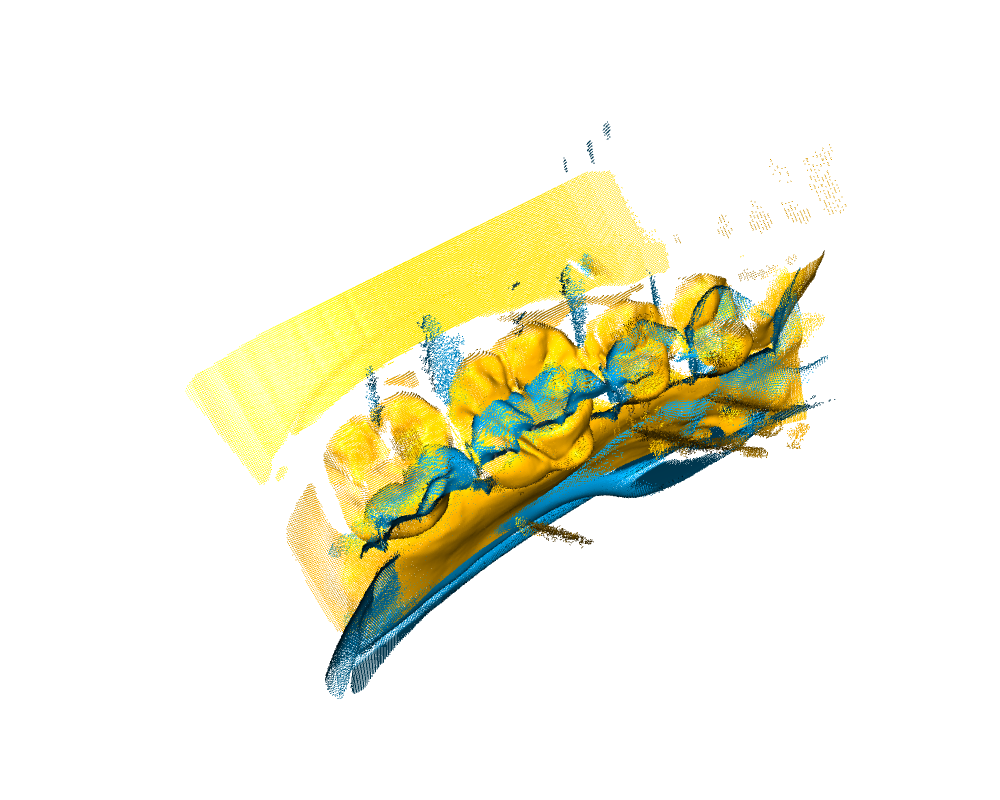

In [39]:
## lets visualize the "best transformation" as per number of overlapping points
tstring = mytimestamp()
custom_draw_geometry(newpointcloud,
                     mytitle = tstring+"wrongly_stitched_seq_0_12",
                     params = myparams,  # parameter for camera point view, json file via pressing P
                     configuration_file = myconfiguration_file, # configuration file for properties, json file via pressing o
                     take_screen_shot = True,
                     rotate = False)

# after manual changing in visualization mode
# selecting a specific one to show the point
newest = last_file_containing("wrongly_stitched_seq_0_12", extension = '.png')
Im(filename=newest,width = 800)

In [46]:
index_best_attempt,best_registration_icp,best_transformation,list_all_results_ordered= extract_best_result_and_transformation(all_results)
index_best_attempt

11

So, the "optimal" in terms of number of overlapping points is not really good...

## Evaluation of registration parameters

In [47]:
for k,v in all_results.items():
    print (f"\n{k}{dash}")
    print (f" GLOBAL: \n  fitness: {v[0].fitness} \n  inlier_rmse: {v[0].inlier_rmse} \n  correspondence_set: {len(np.asarray(v[0].correspondence_set))}")
    print (f" ICP: \n  fitness: {v[1].fitness} \n  inlier_rmse: {v[1].inlier_rmse} \n  correspondence_set: {len(np.asarray(v[1].correspondence_set))}")


1--------------------------------------------------------------------------------
 GLOBAL: 
  fitness: 0.004497751124437781 
  inlier_rmse: 0.22297364624010615 
  correspondence_set: 33
 ICP: 
  fitness: 0.17795703736853882 
  inlier_rmse: 0.1631932084439626 
  correspondence_set: 79529

2--------------------------------------------------------------------------------
 GLOBAL: 
  fitness: 0.004634046613057108 
  inlier_rmse: 0.2188421822971076 
  correspondence_set: 34
 ICP: 
  fitness: 0.17920787648243455 
  inlier_rmse: 0.17219434087009403 
  correspondence_set: 80088

3--------------------------------------------------------------------------------
 GLOBAL: 
  fitness: 0.003816273681341148 
  inlier_rmse: 0.21753624743376138 
  correspondence_set: 28
 ICP: 
  fitness: 0.19471917654956367 
  inlier_rmse: 0.169974338378458 
  correspondence_set: 87020

4--------------------------------------------------------------------------------
 GLOBAL: 
  fitness: 0.007632547362682296 
  inlier

In [48]:
#plot the fitness function of all the attempts

x = list(range(1,len(all_results.keys())+1,1))
x_label = [e for e in x if e%10 == 0]
# red dashes, blue squares and green triangles

global_fitness_list = [v[0].fitness for k,v in all_results.items()]
global_inlier_rmse_list = [v[0].inlier_rmse for k,v in all_results.items()]
global_correspondence_set_list = [len(np.asarray(v[0].correspondence_set)) for k,v in all_results.items()]

global_parameters = [global_fitness_list,global_inlier_rmse_list,global_correspondence_set_list]
global_parameters_labels = ["global_fitness_list","global_inlier_rmse_list","global_correspondence_set_list"]

icp_fitness_list = [v[1].fitness for k,v in all_results.items()]
icp_inlier_rmse_list = [v[1].inlier_rmse for k,v in all_results.items()]
icp_correspondence_set_list = [len(np.asarray(v[1].correspondence_set)) for k,v in all_results.items()]

icp_parameters = [icp_fitness_list,icp_inlier_rmse_list,icp_correspondence_set_list]
icp_parameters_labels = ["icp_fitness_list","icp_inlier_rmse_list","icp_correspondence_set_list"]

symbols = ["o","^","s"]
colors = ["b","r"]

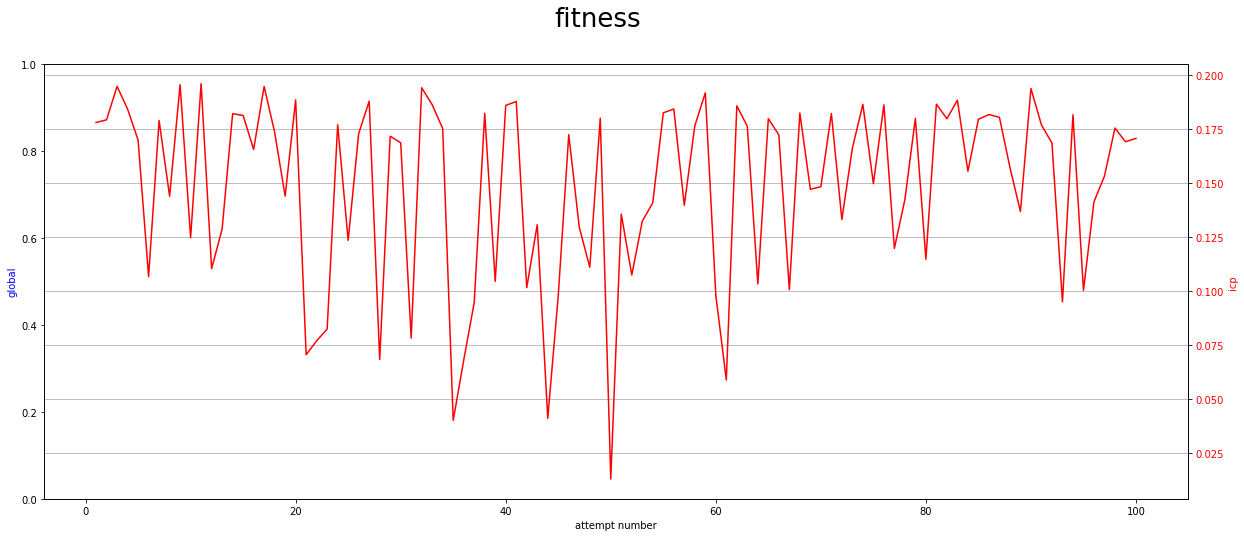

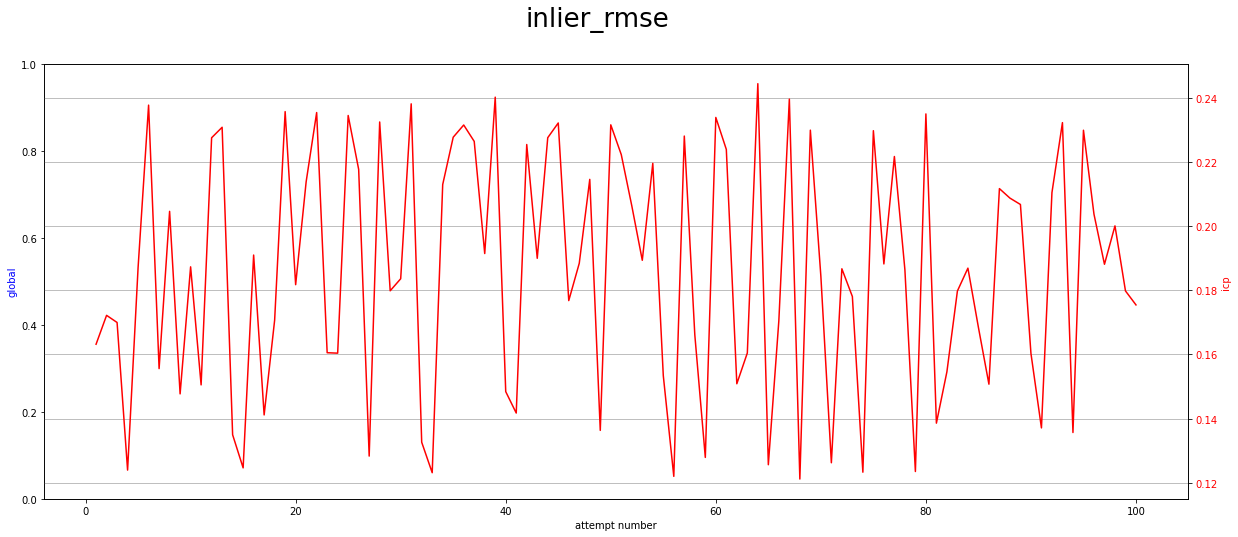

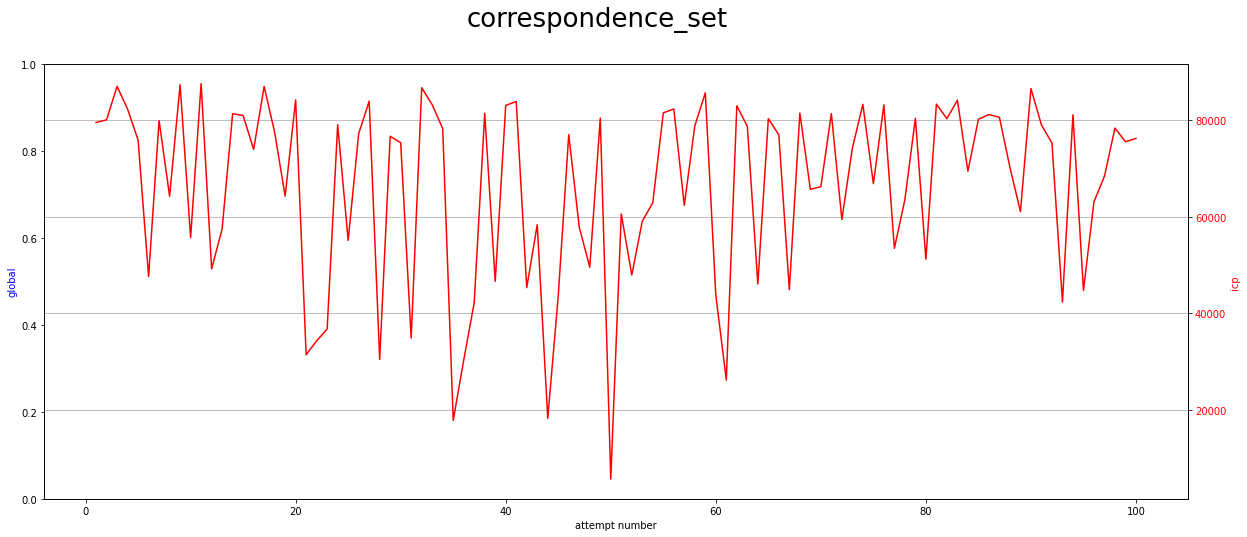

In [51]:
plot_global = False
plot_icp = True

for i in range(len(icp_parameters_labels)):
    
    fig, ax1 = plt.subplots()
    fig.set_size_inches(20.5, 8)
    fig.suptitle(f'{icp_parameters_labels[i][4:-5]}', fontsize=26)
    
    ax1.set_xlabel('attempt number')
    ax1.set_ylabel('global', color=colors[0])
    if plot_global == True: 
        ax1.plot(x, 
                 global_parameters[i], 
                 colors[0],
                 #colors[0]+symbols[0], 
                 label=global_parameters_labels[i])
        ax1.tick_params(axis='y', labelcolor=colors[0])
        ax1.set_xticks(x_label, minor=False)
    
    if plot_icp == True:
        ax2 = ax1.twinx()
        ax2.set_ylabel('icp', color=colors[1]) 
        ax2.plot(x, 
                 icp_parameters[i],
                 colors[1],
                 #colors[1]+symbols[1], 
                 label=icp_parameters_labels[i]) 
        ax2.tick_params(axis='y', labelcolor=colors[1])
    #ax2.legend(loc = "best")
    
    plt.grid()
    plt.show()

Both Fitness and correspondence set seem to give us an indication of where the minima that we are looking for could lie.

Looking at the last plot, "Correspondence Set".

We can observe is that despite giving the highest correspondence_set for icp registration, attempt 7 has also ne of the lowest correspondence_set for global registration.

More over most of the results of icp seem to lie sligly under 90000, while their global icp correspondence sets are in general high, but also vary between 20 and 60.

### Estimation of appropriate overlapping required

We aim to have a corrspondence set that lies in the mean.

In [52]:
from scipy import stats
print (stats.describe(icp_correspondence_set_list))
np.mean(icp_correspondence_set_list)

DescribeResult(nobs=100, minmax=(5730, 87568), mean=66422.86, variance=356581866.16202015, skewness=-1.0282446945433816, kurtosis=0.26252022842046463)


66422.86

In [53]:
evaluated_overlapping = round(np.mean(icp_correspondence_set_list)/len(np.asarray(target.points)),2)
evaluated_overlapping

0.29

## Repeat with lower overlapping

In [54]:
i = 0
#j = 2

target_label = labels_stitches[i][9:] # just labels parsing
source_label = "stitched_seq_1_2"
target = list_stitches[i]
source = stitched_seq_1_2

start = timer()
new_source, new_target, newpointcloud ,all_results = stitching_new(
                                                                    #input 
                                                                    source = source, 
                                                                    target = target, 
                                                                    labels= [source_label,target_label],

                                                                    #downsampling 
                                                                    downsampling_voxel_size = 0.1,
                                                                    limit_size_point_cloud = 50000,

                                                                    #registration
                                                                    voxel_size = 0.2,
                                                                    mmax_iteration = 10**7,
                                                                    mmax_validation = 0.7,

                                                                    # quality control of the stitching
                                                                    myoverlapping_factor = evaluated_overlapping,
                                                                    maxnumattempts = 10,

                                                                    # visualization and pringtng parameters
                                                                    trans_init = None, # keep the possibility of starting directly the ICP
                                                                    print_statements = True,
                                                                    save_statements = False,
                                                                    visualization_on = False,
                                                                    final_vis_on = True,
                                                                    params = myparams,  
                                                                    configuration_file = myconfiguration_file
                                                                 )

end = timer()

print ("duration:",(end-start))

stitch_stitched_seq_1_2_External

DOWNSAMPLING BIG CLOUDS

stitched_seq_1_2
Downsampling stitched_seq_1_2 from 446900 points with voxel size 0.1 
Downsampling stitched_seq_1_2 from 134176 points with voxel size 0.15 
Downsampling stitched_seq_1_2 from 69668 points with voxel size 0.2 
Processed stitched_seq_1_2 has 40997 points 

External
Downsampling External from 230491 points with voxel size 0.1 
Downsampling External from 92802 points with voxel size 0.15 
Downsampling External from 55129 points with voxel size 0.2 
Processed External has 33279 points 

DATA PREPARATION
removing outliers
value to reach:  66842.39
source has 446900 points
target has 230491 points
----------------------------------------------------------------------------------------------------
ATTEMPT 1

GLOBAL REGISTRATION: RANSAC registration on downsampled point clouds.
RegistrationResult with fitness=6.678479e-03, inlier_rmse=1.956878e-01, and correspondence_set size of 49
Access transformation to get result.


We have got an acceptable result in one run.

[Open3D WARNING] GLFW Error: The GLFW library is not initialized


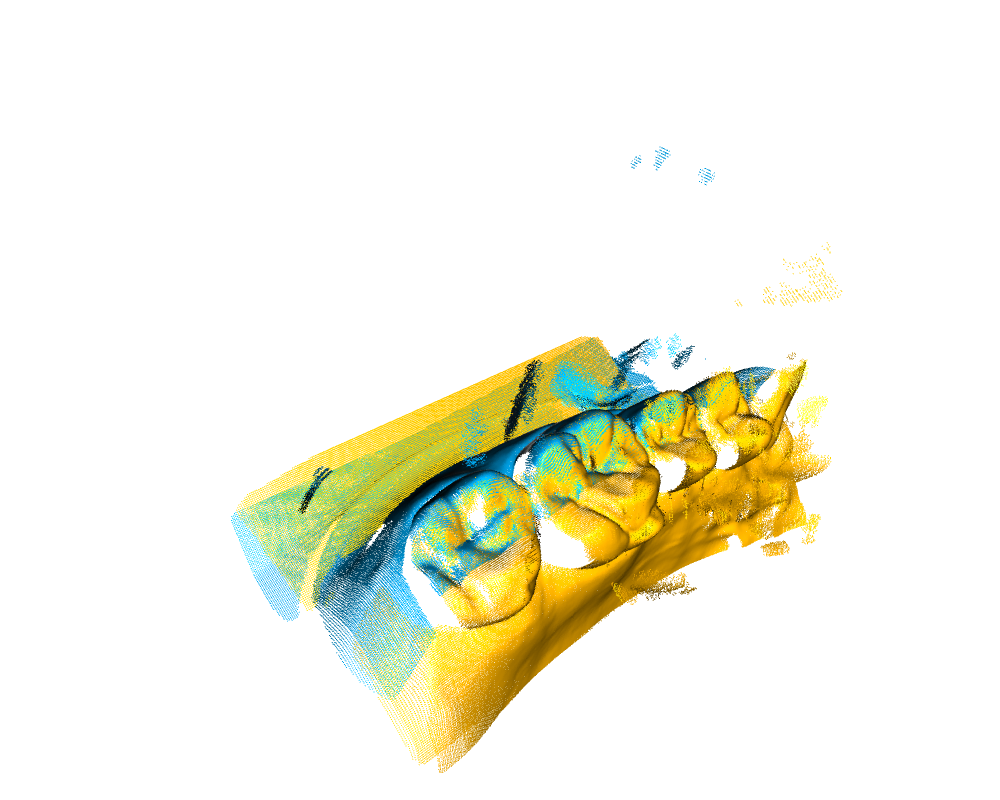

In [17]:
#o3d.visualization.draw_geometries([list_new_pointclouds[-1]])
lower_overlapping_stitched_seq_0_12 = newpointcloud
lower_overlapping_results_stitching_0_12 = all_results
tstring = mytimestamp()

custom_draw_geometry(lower_overlapping_stitched_seq_0_12,
                     mytitle = "lower_overlapping_stitched_seq_0_12",
                     params = myparams,  # parameter for camera point view, json file via pressing P
                     configuration_file = myconfiguration_file, # configuration file for properties, json file via pressing o
                     take_screen_shot = False,
                     rotate = "interactive")

# after manual changing in visualization mode
newest = last_file_containing("lower_overlapping_stitched_seq_0_12", extension = '.png')
Im(filename=newest,width = 800)

In [14]:
complete = lower_overlapping_stitched_seq_0_12
get_num_points([complete])

[677391]

In [19]:
#o3d.io.write_point_cloud("complete.pcd", complete)
o3d.io.write_point_cloud("../data/"+mytimestamp()+"complete.pcd", complete)

True

In [18]:
# save
complete= o3d.io.read_point_cloud("../data/"+"complete.pcd")